In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# @title bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


O dataset

In [3]:
df = pd.read_csv('dataset/superstore.csv')

df.head(3)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [4]:
df = df[['Product Name','Order Date', 'Ship Date','Category','Sub-Category','Sales','Quantity']]

In [5]:
df.groupby('Product Name')['Quantity'].sum().sort_values(ascending=False).head(10)

Product Name
Staples                                                       215
Staple envelope                                               170
Easy-staple paper                                             150
Staples in misc. colors                                        86
KI Adjustable-Height Table                                     74
Avery Non-Stick Binders                                        71
Storex Dura Pro Binders                                        71
GBC Premium Transparent Covers with Diagonal Lined Pattern     67
Situations Contoured Folding Chairs, 4/Set                     64
Staple-based wall hangings                                     62
Name: Quantity, dtype: int64

In [6]:
# Filtrar os dados para o produto 'Staples'
df_staples = df[df['Product Name'] == 'Staples']

# Selecionar as colunas 'Order Date' e 'Quantity'
df_staples_ts = df_staples[['Order Date', 'Quantity']].copy()

df_staples_ts['Order Date'] = pd.to_datetime(df_staples_ts['Order Date'])


df_staples_ts = df_staples_ts.groupby('Order Date')['Quantity'].sum().reset_index()

# Definir 'Order Date' como índice
df_staples_ts.set_index('Order Date', inplace=True)

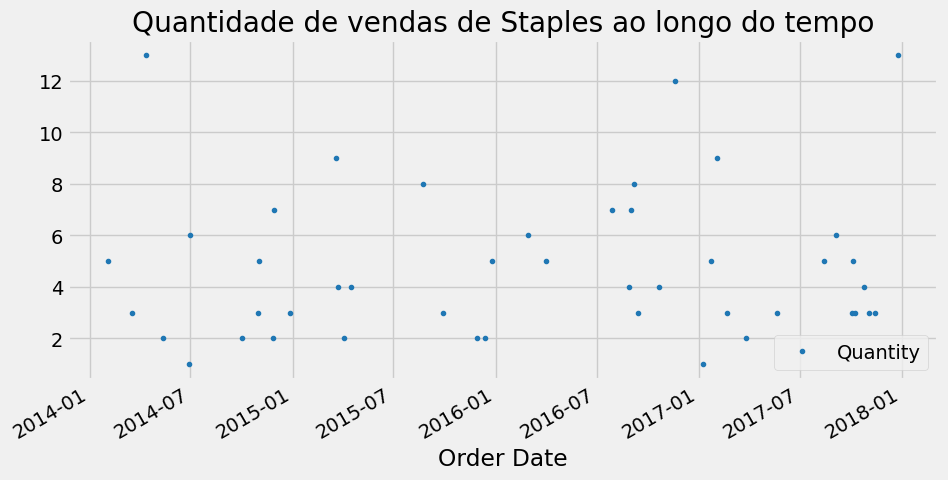

In [8]:
df_staples_ts.plot(style = '.',
        figsize = (10,5),
        color = color_pal[0],
        title = 'Quantidade de vendas de Staples ao longo do tempo')
plt.show()

In [9]:
# tentei aumentar a qtd mas ainda fica mt feio
df_staples_ts['Quantity'] = df_staples_ts['Quantity']*55

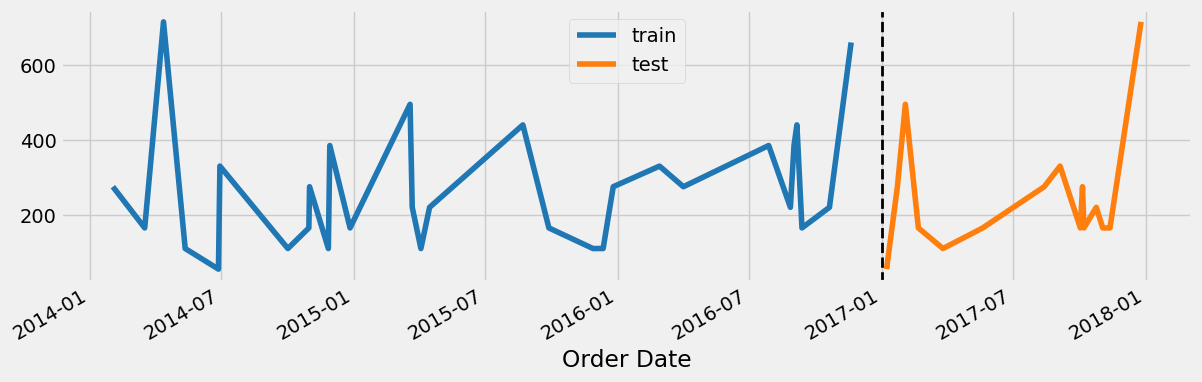

In [10]:
#Train/Test Split

train = df_staples_ts.loc[df_staples_ts.index < '2017-01-01']
test = df_staples_ts.loc[df_staples_ts.index >= '2017-01-01']

fig, ax = plt.subplots(1,1, figsize = (13,4))
train['Quantity'].plot(ax=ax, color = color_pal[0])
test['Quantity'].plot(ax=ax, color = color_pal[1])
ax.axvline('2017-01-01', color = 'black', linestyle = '--', lw = 2)
ax.legend(['train', 'test'])
plt.show()

In [11]:
len(train), len(test)

(30, 15)

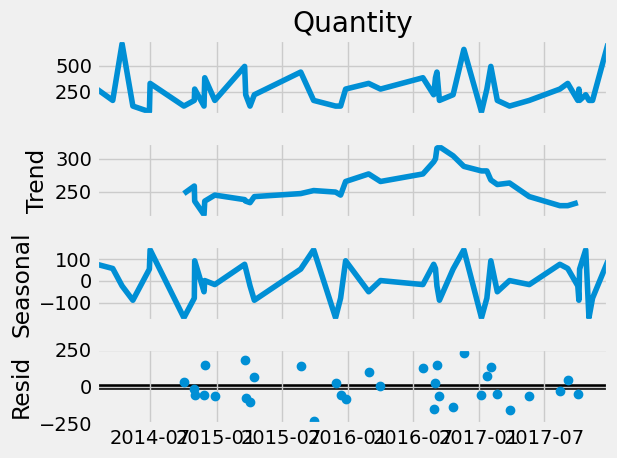

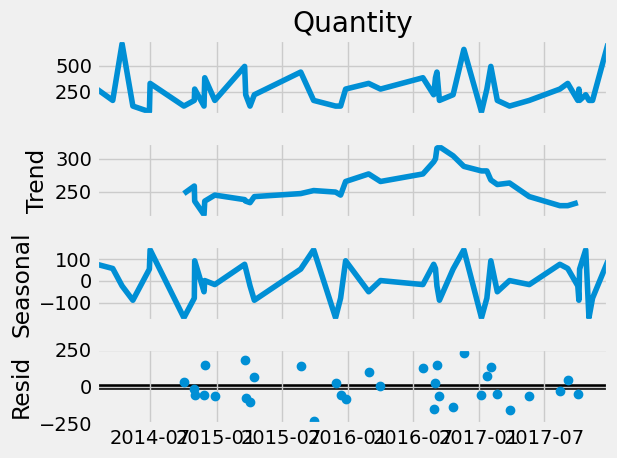

In [12]:

decomposition = seasonal_decompose(df_staples_ts['Quantity'], model='additive', period=12)
decomposition.plot()

In [13]:
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [14]:
df_staples_ts = create_features(df_staples_ts)

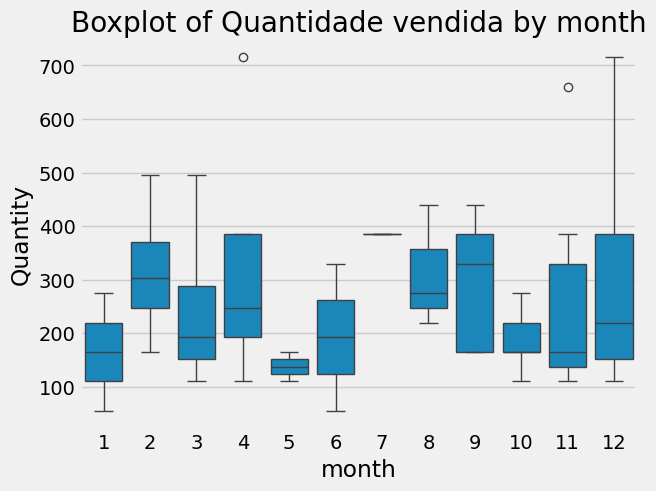

In [15]:
fig, ax = plt.subplots()
sns.boxplot(data = df_staples_ts, x = 'month', y = 'Quantity', ax = ax)
ax.set(title = 'Boxplot of Quantidade vendida by month')
plt.show()

In [16]:
train = create_features(train)
test = create_features(test)

FEATURES = [ 'dayofweek', 'quarter', 'month', 'year','dayofyear']
TARGET = 'Quantity'

X_train, X_test = train[FEATURES], test[FEATURES]
y_train, y_test = train[TARGET], test[TARGET]

In [17]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50,learning_rate = 0.01)
reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],

        verbose = 100)

[0]	validation_0-rmse:159.31577	validation_1-rmse:161.43116
[100]	validation_0-rmse:94.31839	validation_1-rmse:151.89223
[136]	validation_0-rmse:80.02727	validation_1-rmse:153.61304


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [18]:
# index se refere às linhas
fi = pd.DataFrame(reg.feature_importances_,
                  index = reg.feature_names_in_,
                  columns = ['importance'])

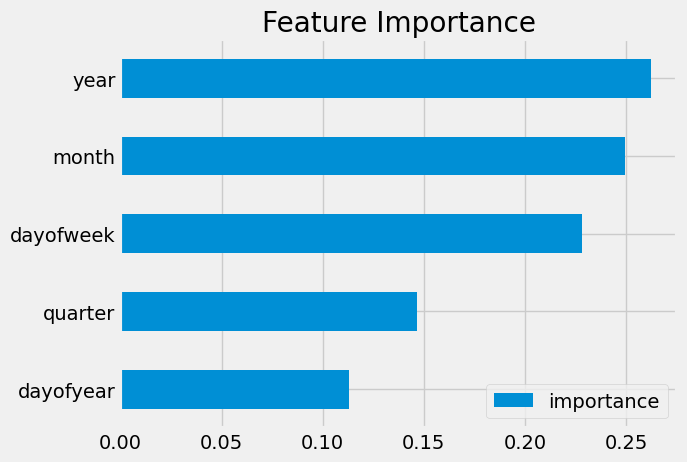

In [19]:
fi.sort_values('importance', ascending = True).plot(kind = 'barh', title = 'Feature Importance')
plt.show()

In [20]:
test['Prediction'] = reg.predict(X_test)
df_staples_ts = df_staples_ts.merge(test[['Prediction']], how = 'left', left_index = True, right_index = True)

In [21]:
df_staples_ts.head()

,Quantity,dayofweek,quarter,month,year,dayofyear,Prediction
Order Date,,,,,,,
2014-02-02,275,6,1,2,2014,33,NaN
2014-03-18,165,1,1,3,2014,77,NaN
2014-04-13,715,6,2,4,2014,103,NaN
2014-05-13,110,1,2,5,2014,133,NaN
2014-06-28,55,5,2,6,2014,179,NaN


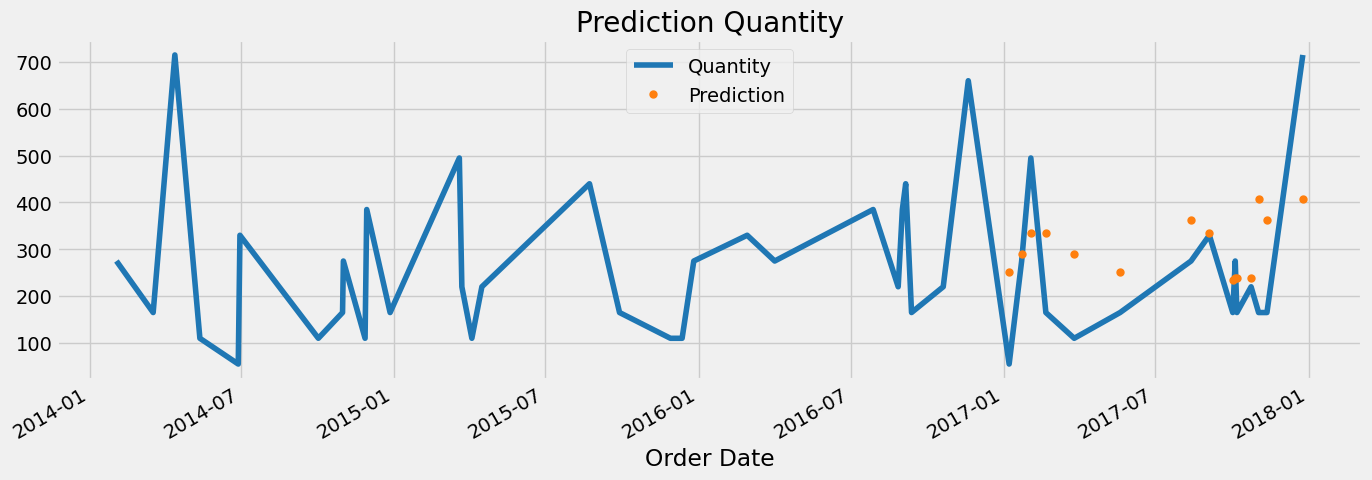

In [31]:
ax = df_staples_ts[['Quantity']].plot(figsize = (15,5), color = color_pal[0])
df_staples_ts[['Prediction']].plot(ax = ax, color = color_pal[1], style = '.', markersize=10)
ax.set(title = 'Prediction Quantity')
plt.show()

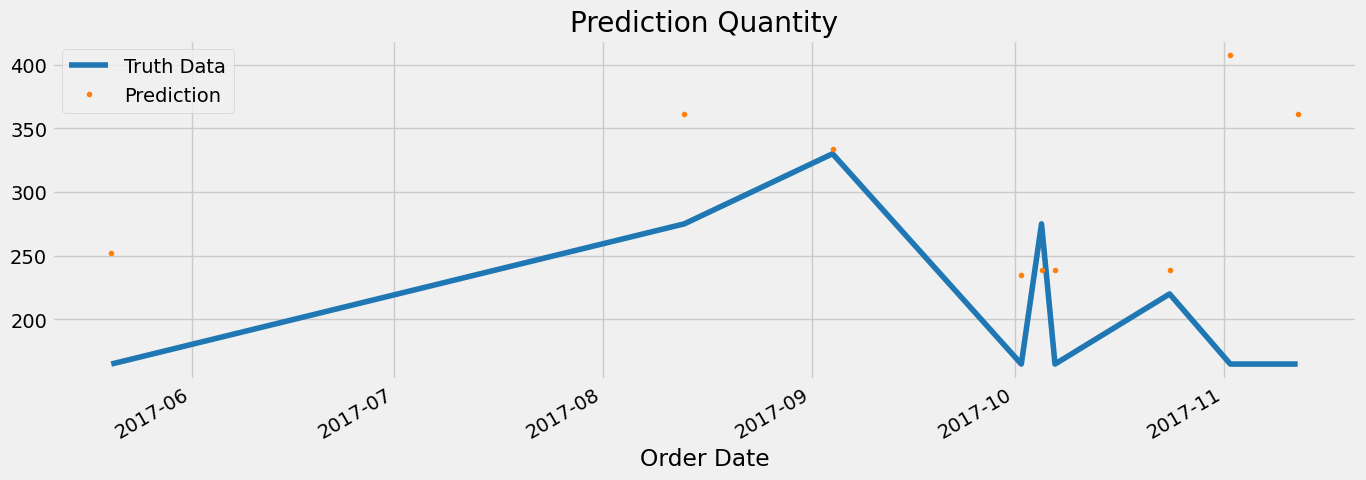

In [30]:
ax = df_staples_ts.loc[(df_staples_ts.index > '2017-04-01') & (df_staples_ts.index < '2017-12-01') ]['Quantity'].plot(figsize = (15,5), color = color_pal[0])
df_staples_ts.loc[(df_staples_ts.index  > '2017-04-01') & (df_staples_ts.index  < '2017-12-01') ]['Prediction'].plot(figsize = (15,5), color = color_pal[1], style = '.')
ax.set(title = 'Prediction Quantity')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [32]:
score = np.sqrt(mean_squared_error(test['Quantity'], test['Prediction']))
score

151.7172700098348

In [33]:
test['error'] = abs(test['Quantity'] - test['Prediction'])
test['date'] = test.index.date

#worst predictions

test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2017-12-25    307.481140
2017-11-02    242.518860
2017-01-07    197.004654
2017-11-12    196.559723
2017-03-26    180.883209
Name: error, dtype: float64

In [34]:
# best predictions
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2017-09-04     3.811920
2017-01-22    15.883209
2017-10-24    18.616074
2017-10-05    36.383926
2017-10-02    69.632385
Name: error, dtype: float64

# Conclusions and Next steps

- Não to sabendo interpretar mt bem o RSME
- Criar mais dados sintéticos. Todo mês ter venda. 
- Aumentar a qtd de anos? Acho que ter mts meses é mais importante.
- Não estou mt atento a usar algumas coisas q foram passadas em aula.
- Pq n ta prevendo bem?
- Testar outros modelos.